# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

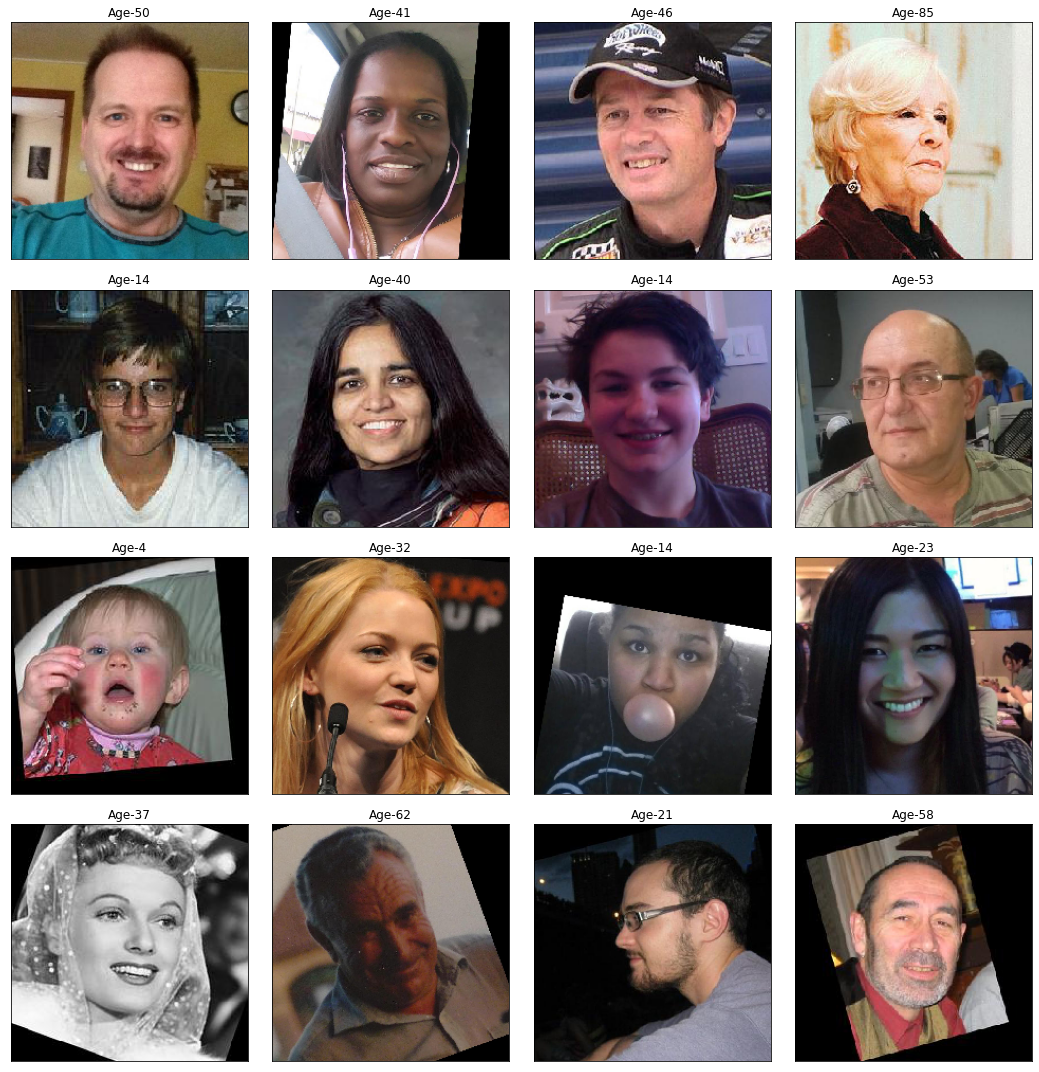

In [4]:

fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4,i+1)
    plt.title(f"Age-{target[i]}")
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [5]:
features.shape

(32, 224, 224, 3)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
labels.head(12)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


В нашем расоряжении выборка с цветными фотографиями в количестве 7591 шт. и размером 224x224 разделённая на множество слоёв (батчей) по 32 тренировочных объекта в каждом. Таким образом если обучать весь датасет, то нам потребуется 237 итреаций на одну эпоху.

Выведем распределение по возрастам.

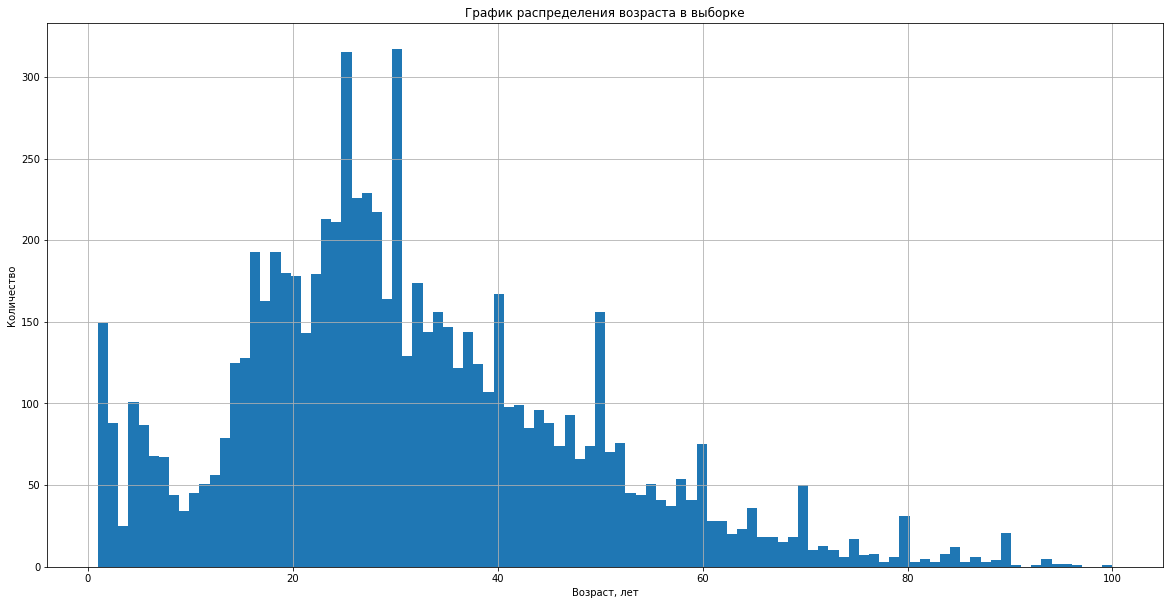

In [9]:
labels['real_age'].plot(kind='hist',figsize = (20,10), bins=100, grid=True);
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество');

In [10]:
age = labels.pivot_table(index='real_age', values='real_age', aggfunc=['count'])
age.columns = ['count']
age

,count
real_age,
1,149
2,88
3,25
4,101
5,87
...,...
94,5
95,2
96,2


Объем датасета составляет порядком 7591 фотографий. 
В данномдататсете пристутсвуют как чернобелые фотографии так и цветные, так же присутствую фотографии с различными предметами на переднем плане(жевачка, микрофонб, рука), есть повернутые под углом фото.  

Разбирая гистограмму сформированную по датасету, видим "всплекс" кол-ва фотографий для возрастов:
- дети (1-2 года);
- несовершеннолетние (диапазон 16-21 год)
- молодежь (25,30 лет)
- и далее через 10-ток

Скорей всего у модели будет точность выше на фотографиях людей 25-30 лет так как обучающих данных больше в этом диапазоне и низкая точность определения возраста после 60 лет. Есть пики и до 40 и после 40, 50, 60 лет.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    labels_df = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        height_shift_range=0.1,
        width_shift_range=0.1)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='training',
        seed=12345
    )


    return train_datagen_flow

def load_test(path):

    labels_df = pd.read_csv(path + 'labels.csv')

    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='validation',
        seed=12345)

    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 235s - loss: 237.3849 - mae: 11.0310 - val_loss: 842.3120 - val_mae: 24.1335
Epoch 2/6
178/178 - 92s - loss: 87.9517 - mae: 7.1179 - val_loss: 720.7807 - val_mae: 21.6948
Epoch 3/6
178/178 - 90s - loss: 67.2255 - mae: 6.2469 - val_loss: 233.5154 - val_mae: 11.3370
Epoch 4/6
178/178 - 101s - loss: 52.8326 - mae: 5.5309 - val_loss: 217.2647 - val_mae: 11.4825
Epoch 5/6
178/178 - 98s - loss: 41.4236 - mae: 4.9701 - val_loss: 80.5503 - val_mae: 6.5002
Epoch 6/6
178/178 - 99s - loss: 37.5322 - mae: 4.7245 - val_loss: 72.8581 - val_mae: 6.2979
60/60 - 11s - loss: 72.8581 - mae: 6.2979

Test MAE: 6.2979

```

## Анализ обученной модели

Анализ обученной модели показывает, что модель на основе ResNet50 с достигнутым значением MAE 6.2979 способна достаточно точно определять возрастные категории. Более конкретно, модель показывает высокую точность в определении возрастных групп от 20 до 40 лет, что отражается в меньшем значении MAE для этого диапазона возрастов. Однако, для остальных возрастных групп можно ожидать более высоких значений MAE.